In [28]:
#Librerias que se utilizaran
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import duckdb
import glob
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import euclidean_distances
import datetime
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error


# Librerias astrofisica
# =============================================================================
from astroquery.mast import Observations
import lightkurve as lk
from astropy.time import Time

con = duckdb.connect(database=':memory:')


## Conteo de estrellas por clase

In [12]:
Carac_Stars = pd.read_csv('Carac_Stars.csv')
Carac_Stars

,Kepler_ID,Metalicidad,Clasificacion,incert_clas
0,10797460,0.136,CANDIDATE,1.000
1,10811496,-0.127,FALSE POSITIVE,0.000
2,10848459,-0.522,FALSE POSITIVE,0.000
3,10854555,0.081,CANDIDATE,1.000
4,10872983,-0.067,CANDIDATE,0.992
...,...,...,...,...
7677,10128825,-0.046,CANDIDATE,0.497
7678,10147276,-0.038,FALSE POSITIVE,0.021
7679,10156110,0.082,FALSE POSITIVE,0.000
7680,8460634,-0.556,FALSE POSITIVE,0.000


In [4]:
Carac_Stars[Carac_Stars['Kepler_ID']==10004515]

,Kepler_ID,Metalicidad,Clasificacion,incert_clas
4962,10004515,-0.511,FALSE POSITIVE,NaN


In [5]:
con.execute("""select Clasificacion, count(*)
               from Carac_Stars
               group by Clasificacion""").df()

,Clasificacion,count_star()
0,CANDIDATE,3246
1,FALSE POSITIVE,4436


## Descripción de las series de tiempo

### Registros en el tiempo

In [19]:
url_lc = "../Curvas_de_luz/"

In [20]:
#Ver una curva de luz
arch = os.listdir(url_lc) #arch es un arreglo de todos los csv 
serie = pd.read_csv(url_lc+arch[4]) #serie es el contenido del archivo url_lc+arch[4]
serie

,time,flux,flux_err
0,131.512125,-0.915257,4.767483
1,131.532559,-0.941187,4.773526
2,131.552994,-0.954348,4.774362
3,131.573428,-1.021330,4.774106
4,131.593862,-0.761243,4.779107
...,...,...,...
65026,1590.919491,-0.406112,4.803519
65027,1590.939926,-0.332450,4.806564
65028,1590.960360,-0.375717,4.803618
65029,1590.980794,-0.705561,4.806317


In [14]:
#Los datos se encuentran en bkjd (Barycentric Kepler Julian Date)
time = Time(serie['time'], format='bkjd')  # Crear un objeto Time de astropy
datetime_time = time.datetime  # Convertir a datetime
help(datetime_time[0])

Help on datetime object:

class datetime(date)
 |  datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]])
 |  
 |  The year, month and day arguments are required. tzinfo may be None, or an
 |  instance of a tzinfo subclass. The remaining arguments may be ints.
 |  
 |  Method resolution order:
 |      datetime
 |      date
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __le__(self, value, /)
 |      Return self<=value.
 |  
 |  __lt__(self, value, /)
 |      Return self<value.
 |  
 |  __ne__(self, value, /)
 |      Return self!=value.
 |  
 |  __radd__(self, value, /)
 |      Retur

In [17]:
datetime_time[0]

datetime.datetime(2013, 4, 9, 17, 25, 13, 565184)

In [6]:
# Directorio de curvas de luz con fecha en formato gregoriano
url_lcc = "../Curvas_de_luz_arregladas/"

In [16]:
arch = os.listdir(url_lc)

for star_lc in arch:
    #Se pasa la curva de luz a un dataframe de pandas
    serie = pd.read_csv(url_lc+star_lc)
    
    #Se elimina la primera fila con valores NA
    serie = serie.dropna()
    
    #Se transforman los tiempos a datatime
    time = Time(serie['time'], format='bkjd') #Time retorna un objeto time para el cual esta definida la funcion .datatime. Lib Astrophy
    serie['time'] = time.datetime 
    
    #Guardo la serie arreglada
    serie.to_csv(f'{url_lcc}{star_lc}', index=False) #index=False es para no contar los datos con 1, 2, 3.. por fila

## Descripción de las curvas de luz

In [3]:
#Ver una curva de luz
url_lcc = "Curvas_de_luz_arregladas/"
arch_cor = os.listdir(url_lcc)
summary_series = [] 
num_series = len(arch_cor) #length de arch_cor, el número de curvas

for i in range(num_series):
    # Importación de cada curva de luz
    serie_cor = pd.read_csv(url_lcc+arch_cor[i])
    
    # Extraer longitud de la curva, shape[0] es número de filas, shape[1] es número de columnas
    num_datos = serie_cor.shape[0]
    
    # Extraer la primera y última fecha y hora para las cuales se tiene info en cada curva, 
    summary_series.append([arch_cor[i][3:-4], num_datos, serie_cor['time'][0], serie_cor['time'][num_datos-1]])
   
    # Avance del for
    print(np.round(i*100/num_series, 2))


0.0
0.01
0.03
0.04
0.05
0.07
0.08
0.09
0.1
0.12
0.13
0.14
0.16
0.17
0.18
0.2
0.21
0.22
0.23
0.25
0.26
0.27
0.29
0.3
0.31
0.33
0.34
0.35
0.36
0.38
0.39
0.4
0.42
0.43
0.44
0.46
0.47
0.48
0.49
0.51
0.52
0.53
0.55
0.56
0.57
0.59
0.6
0.61
0.62
0.64
0.65
0.66
0.68
0.69
0.7
0.72
0.73
0.74
0.76
0.77
0.78
0.79
0.81
0.82
0.83
0.85
0.86
0.87
0.89
0.9
0.91
0.92
0.94
0.95
0.96
0.98
0.99
1.0
1.02
1.03
1.04
1.05
1.07
1.08
1.09
1.11
1.12
1.13
1.15
1.16
1.17
1.18
1.2
1.21
1.22
1.24
1.25
1.26
1.28
1.29
1.3
1.31
1.33
1.34
1.35
1.37
1.38
1.39
1.41
1.42
1.43
1.44
1.46
1.47
1.48
1.5
1.51
1.52
1.54
1.55
1.56
1.58
1.59
1.6
1.61
1.63
1.64
1.65
1.67
1.68
1.69
1.71
1.72
1.73
1.74
1.76
1.77
1.78
1.8
1.81
1.82
1.84
1.85
1.86
1.87
1.89
1.9
1.91
1.93
1.94
1.95
1.97
1.98
1.99
2.0
2.02
2.03
2.04
2.06
2.07
2.08
2.1
2.11
2.12
2.13
2.15
2.16
2.17
2.19
2.2
2.21
2.23
2.24
2.25
2.27
2.28
2.29
2.3
2.32
2.33
2.34
2.36
2.37
2.38
2.4
2.41
2.42
2.43
2.45
2.46
2.47
2.49
2.5
2.51
2.53
2.54
2.55
2.56
2.58
2.59
2.6
2.62
2.63
2.64
2.

19.77
19.79
19.8
19.81
19.83
19.84
19.85
19.86
19.88
19.89
19.9
19.92
19.93
19.94
19.96
19.97
19.98
19.99
20.01
20.02
20.03
20.05
20.06
20.07
20.09
20.1
20.11
20.12
20.14
20.15
20.16
20.18
20.19
20.2
20.22
20.23
20.24
20.26
20.27
20.28
20.29
20.31
20.32
20.33
20.35
20.36
20.37
20.39
20.4
20.41
20.42
20.44
20.45
20.46
20.48
20.49
20.5
20.52
20.53
20.54
20.55
20.57
20.58
20.59
20.61
20.62
20.63
20.65
20.66
20.67
20.68
20.7
20.71
20.72
20.74
20.75
20.76
20.78
20.79
20.8
20.81
20.83
20.84
20.85
20.87
20.88
20.89
20.91
20.92
20.93
20.95
20.96
20.97
20.98
21.0
21.01
21.02
21.04
21.05
21.06
21.08
21.09
21.1
21.11
21.13
21.14
21.15
21.17
21.18
21.19
21.21
21.22
21.23
21.24
21.26
21.27
21.28
21.3
21.31
21.32
21.34
21.35
21.36
21.37
21.39
21.4
21.41
21.43
21.44
21.45
21.47
21.48
21.49
21.5
21.52
21.53
21.54
21.56
21.57
21.58
21.6
21.61
21.62
21.63
21.65
21.66
21.67
21.69
21.7
21.71
21.73
21.74
21.75
21.77
21.78
21.79
21.8
21.82
21.83
21.84
21.86
21.87
21.88
21.9
21.91
21.92
21.93
21.95
21.96
21.

37.85
37.87
37.88
37.89
37.91
37.92
37.93
37.95
37.96
37.97
37.98
38.0
38.01
38.02
38.04
38.05
38.06
38.08
38.09
38.1
38.12
38.13
38.14
38.15
38.17
38.18
38.19
38.21
38.22
38.23
38.25
38.26
38.27
38.28
38.3
38.31
38.32
38.34
38.35
38.36
38.38
38.39
38.4
38.41
38.43
38.44
38.45
38.47
38.48
38.49
38.51
38.52
38.53
38.54
38.56
38.57
38.58
38.6
38.61
38.62
38.64
38.65
38.66
38.67
38.69
38.7
38.71
38.73
38.74
38.75
38.77
38.78
38.79
38.8
38.82
38.83
38.84
38.86
38.87
38.88
38.9
38.91
38.92
38.94
38.95
38.96
38.97
38.99
39.0
39.01
39.03
39.04
39.05
39.07
39.08
39.09
39.1
39.12
39.13
39.14
39.16
39.17
39.18
39.2
39.21
39.22
39.23
39.25
39.26
39.27
39.29
39.3
39.31
39.33
39.34
39.35
39.36
39.38
39.39
39.4
39.42
39.43
39.44
39.46
39.47
39.48
39.49
39.51
39.52
39.53
39.55
39.56
39.57
39.59
39.6
39.61
39.63
39.64
39.65
39.66
39.68
39.69
39.7
39.72
39.73
39.74
39.76
39.77
39.78
39.79
39.81
39.82
39.83
39.85
39.86
39.87
39.89
39.9
39.91
39.92
39.94
39.95
39.96
39.98
39.99
40.0
40.02
40.03
40.04
40.

55.96
55.98
55.99
56.0
56.01
56.03
56.04
56.05
56.07
56.08
56.09
56.11
56.12
56.13
56.14
56.16
56.17
56.18
56.2
56.21
56.22
56.24
56.25
56.26
56.27
56.29
56.3
56.31
56.33
56.34
56.35
56.37
56.38
56.39
56.4
56.42
56.43
56.44
56.46
56.47
56.48
56.5
56.51
56.52
56.53
56.55
56.56
56.57
56.59
56.6
56.61
56.63
56.64
56.65
56.66
56.68
56.69
56.7
56.72
56.73
56.74
56.76
56.77
56.78
56.8
56.81
56.82
56.83
56.85
56.86
56.87
56.89
56.9
56.91
56.93
56.94
56.95
56.96
56.98
56.99
57.0
57.02
57.03
57.04
57.06
57.07
57.08
57.09
57.11
57.12
57.13
57.15
57.16
57.17
57.19
57.2
57.21
57.22
57.24
57.25
57.26
57.28
57.29
57.3
57.32
57.33
57.34
57.35
57.37
57.38
57.39
57.41
57.42
57.43
57.45
57.46
57.47
57.49
57.5
57.51
57.52
57.54
57.55
57.56
57.58
57.59
57.6
57.62
57.63
57.64
57.65
57.67
57.68
57.69
57.71
57.72
57.73
57.75
57.76
57.77
57.78
57.8
57.81
57.82
57.84
57.85
57.86
57.88
57.89
57.9
57.91
57.93
57.94
57.95
57.97
57.98
57.99
58.01
58.02
58.03
58.04
58.06
58.07
58.08
58.1
58.11
58.12
58.14
58.15
58.

74.06
74.07
74.08
74.1
74.11
74.12
74.13
74.15
74.16
74.17
74.19
74.2
74.21
74.23
74.24
74.25
74.26
74.28
74.29
74.3
74.32
74.33
74.34
74.36
74.37
74.38
74.39
74.41
74.42
74.43
74.45
74.46
74.47
74.49
74.5
74.51
74.52
74.54
74.55
74.56
74.58
74.59
74.6
74.62
74.63
74.64
74.66
74.67
74.68
74.69
74.71
74.72
74.73
74.75
74.76
74.77
74.79
74.8
74.81
74.82
74.84
74.85
74.86
74.88
74.89
74.9
74.92
74.93
74.94
74.95
74.97
74.98
74.99
75.01
75.02
75.03
75.05
75.06
75.07
75.08
75.1
75.11
75.12
75.14
75.15
75.16
75.18
75.19
75.2
75.21
75.23
75.24
75.25
75.27
75.28
75.29
75.31
75.32
75.33
75.34
75.36
75.37
75.38
75.4
75.41
75.42
75.44
75.45
75.46
75.48
75.49
75.5
75.51
75.53
75.54
75.55
75.57
75.58
75.59
75.61
75.62
75.63
75.64
75.66
75.67
75.68
75.7
75.71
75.72
75.74
75.75
75.76
75.77
75.79
75.8
75.81
75.83
75.84
75.85
75.87
75.88
75.89
75.9
75.92
75.93
75.94
75.96
75.97
75.98
76.0
76.01
76.02
76.03
76.05
76.06
76.07
76.09
76.1
76.11
76.13
76.14
76.15
76.17
76.18
76.19
76.2
76.22
76.23
76.24
76.

92.14
92.15
92.16
92.18
92.19
92.2
92.22
92.23
92.24
92.25
92.27
92.28
92.29
92.31
92.32
92.33
92.35
92.36
92.37
92.38
92.4
92.41
92.42
92.44
92.45
92.46
92.48
92.49
92.5
92.51
92.53
92.54
92.55
92.57
92.58
92.59
92.61
92.62
92.63
92.65
92.66
92.67
92.68
92.7
92.71
92.72
92.74
92.75
92.76
92.78
92.79
92.8
92.81
92.83
92.84
92.85
92.87
92.88
92.89
92.91
92.92
92.93
92.94
92.96
92.97
92.98
93.0
93.01
93.02
93.04
93.05
93.06
93.07
93.09
93.1
93.11
93.13
93.14
93.15
93.17
93.18
93.19
93.2
93.22
93.23
93.24
93.26
93.27
93.28
93.3
93.31
93.32
93.34
93.35
93.36
93.37
93.39
93.4
93.41
93.43
93.44
93.45
93.47
93.48
93.49
93.5
93.52
93.53
93.54
93.56
93.57
93.58
93.6
93.61
93.62
93.63
93.65
93.66
93.67
93.69
93.7
93.71
93.73
93.74
93.75
93.76
93.78
93.79
93.8
93.82
93.83
93.84
93.86
93.87
93.88
93.89
93.91
93.92
93.93
93.95
93.96
93.97
93.99
94.0
94.01
94.02
94.04
94.05
94.06
94.08
94.09
94.1
94.12
94.13
94.14
94.16
94.17
94.18
94.19
94.21
94.22
94.23
94.25
94.26
94.27
94.29
94.3
94.31
94.32
94.

In [4]:
summary_series = np.array(summary_series)

df_summary_series = pd.DataFrame()
df_summary_series["ID"] = summary_series[:,0]
df_summary_series["Long"] = summary_series[:,1].astype(np.float64)
df_summary_series["Fecha_inicio"] = summary_series[:,2]
df_summary_series["Fecha_final"] = summary_series[:,3]

df_summary_series.to_csv("Curve_Statistics", index=False)
df_summary_series

,ID,Long,Fecha_inicio,Fecha_final
0,9777251,54965.0,2009-12-19 21:32:21.493356,2013-05-11 12:01:38.246659
1,8415745,54964.0,2009-12-19 21:31:43.874328,2013-05-11 12:02:40.881334
2,9528420,64797.0,2009-05-13 00:17:28.661549,2013-05-11 12:01:50.050916
3,5009189,64794.0,2009-05-13 00:18:03.722051,2013-05-11 12:02:06.584268
4,9161118,54965.0,2009-12-19 21:32:13.781534,2013-05-11 12:01:40.483661
...,...,...,...,...
7677,9674789,16248.0,2009-05-13 00:16:43.394454,2013-05-11 12:01:00.973396
7678,10793576,13531.0,2010-06-24 23:16:53.679684,2013-05-11 12:02:00.303740
7679,7256914,64794.0,2009-05-13 00:18:42.455677,2013-05-11 12:03:03.683654
7680,4732015,65261.0,2009-05-02 00:56:54.844466,2013-05-11 12:02:36.357982


In [5]:
df_summary_series = pd.read_csv("Curve_Statistics.csv")
df_summary_series

,ID,Long,Fecha_inicio,Fecha_final
0,9777251,54965.0,2009-12-19 21:32:21.493356,2013-05-11 12:01:38.246659
1,8415745,54964.0,2009-12-19 21:31:43.874328,2013-05-11 12:02:40.881334
2,9528420,64797.0,2009-05-13 00:17:28.661549,2013-05-11 12:01:50.050916
3,5009189,64794.0,2009-05-13 00:18:03.722051,2013-05-11 12:02:06.584268
4,9161118,54965.0,2009-12-19 21:32:13.781534,2013-05-11 12:01:40.483661
...,...,...,...,...
7677,9674789,16248.0,2009-05-13 00:16:43.394454,2013-05-11 12:01:00.973396
7678,10793576,13531.0,2010-06-24 23:16:53.679684,2013-05-11 12:02:00.303740
7679,7256914,64794.0,2009-05-13 00:18:42.455677,2013-05-11 12:03:03.683654
7680,4732015,65261.0,2009-05-02 00:56:54.844466,2013-05-11 12:02:36.357982


In [6]:
print(f'Número mínimo de observaciones temporales: ', np.min(df_summary_series["Long"]))
print(f'Número máximo de observaciones temporales: ', np.max(df_summary_series["Long"]))
print(f'Número promedio de observaciones temporales: ', round(np.mean(df_summary_series["Long"]),2))
print(f'Desviación estándar del número de observaciones temporales: ', round(np.sqrt(np.var(df_summary_series["Long"])),2))
print(f'Los topes superior e inferior que se pueden considerar para filtrar el conjunto de curvas según su número de observaciones son respectivamente:\n', round(np.mean(df_summary_series["Long"]),2)+round(np.sqrt(np.var(df_summary_series["Long"])),2), "\n", round(np.mean(df_summary_series["Long"]),2)-round(np.sqrt(np.var(df_summary_series["Long"])),2))

Número mínimo de observaciones temporales:  1284.0
Número máximo de observaciones temporales:  184557.0
Número promedio de observaciones temporales:  61614.43
Desviación estándar del número de observaciones temporales:  16663.48
Los topes superior e inferior que se pueden considerar para filtrar el conjunto de curvas según su número de observaciones son respectivamente:
 78277.91 
 44950.95


In [7]:
df_summary_final = df_summary_series[(df_summary_series["Long"]<=75000) & (df_summary_series["Long"]>=50000)] 
# filtrar curvas en aquellas cuyos elementos de Long sean <=75000 y mayores a 50000

In [8]:
print(f'Al filtrar las curvas de luz por su longitud se abarca el ', round(df_summary_final.shape[0]*100/df_summary_series.shape[0],2), '%') 
#round(number, n) redondea los decimales hasta n

Al filtrar las curvas de luz por su longitud se abarca el  87.4 %


Como no se reduce mucho el número de curvas al restringir la longitud de las curvas, se van a escoger aquellas que no tengan menos de 50.000 y más de 75.000 obervaciones.
Utilizando como método para igualar las longitudes de lass curvas la **interpolación lineal**, esto para mantener las tendencias temporales

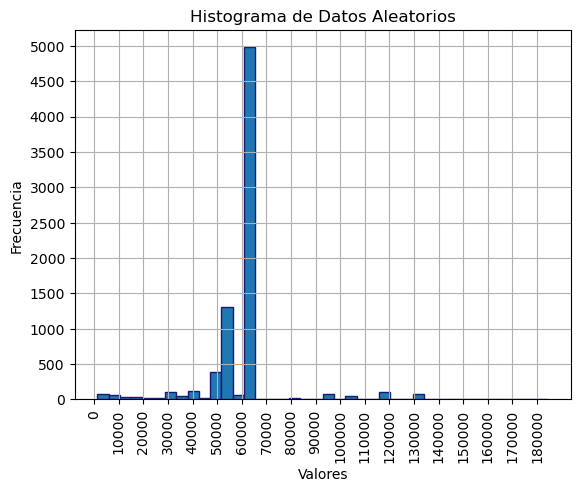

In [9]:
# Histograma
plt.grid(True)
plt.hist(df_summary_series["Long"], bins=40, edgecolor='midnightblue')  # Puedes ajustar el número de bins según sea necesario
plt.xticks(np.arange(0, np.max(df_summary_series["Long"]), 10000), rotation=90)  # Graduación en el eje x de -4 a 4 con incrementos de 1
plt.yticks(np.arange(0, 5500, 500))  # Graduación en el eje y de 0 a 200 con incrementos de 20
plt.title('Histograma de Datos Aleatorios')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

In [11]:
df_summary_final.to_csv("Curve_Statistics.csv", index=False)

## Interpolación de datos

In [29]:
df_summary_final = pd.read_csv("Curve_stat3.csv")
url_lcc = "../Curvas_de_luz_arregladas/"
url_lc_final = "../Curvas_de_luz_God/"

In [30]:
def InfoCurve(serie):
    "Retorna la longitud de la curva y el k"
    
    n = serie.shape[0]
    dates = np.zeros(n, dtype='datetime64[D]')
    for i in range(n):
        dates[i] = serie["time"][i].date() #date extrae solo la fecha de el datetime

    serie["date"] = dates #agrega una columna con fechas sin horas
    frec_dias = pd.crosstab(index=serie["date"],columns="frecuencia") #Cra la tabla de frecuencias
    k = round(np.mean(frec_dias)) # número promedio de observaciones de un dia
    return n,int(k)

In [69]:
def SerieFull(serie):
    '''Retorna una serie con una longitud de 75000 indexada con el tiempo'''
    
    n, k = InfoCurve(serie)
    n_est = 75000-n
    np.random.seed(1312) #np.random es un objeto generador de numeros aleatorios
    random_n = np.random.choice(np.arange(k+1, n), n_est, replace=False) #crea un array de numpy con n_est numerros aleatorios entre 1 y n(posiciones)
    dates_interp =  np.zeros(n_est, dtype='datetime64[s]') #array de fechas zeros

    serie = serie.sort_values(by='time').reset_index(drop=True)

    #determinas las fechas de las posiciones aleatorias
    for d in range(len(random_n)):
        i = random_n[d]
        dif_dates = serie["time"][i] - serie["time"][i-1] 
        dates_interp[d] = serie["time"][i-1] + dif_dates/2


    #creación del dataframe con las fechas y el resto de variables con NaN
    serie_interp = pd.DataFrame() 
    serie_interp["time"] = dates_interp 
    serie_interp["flux"] = [np.nan]*n_est
    serie_interp["flux_err"] = [np.nan] * n_est
    
    #se agrega una columna de fechas sin hora
    dates2 = np.zeros(n_est, dtype='datetime64[D]')
    for i in range(n_est):
        dates2[i] = serie_interp["time"][i].date()
    serie_interp["date"] = dates2
    
    #se concatenan los dataframes, se ordenan por "time" y despues resetean los indices
    serie_full = pd.concat([serie, serie_interp])
    serie_full = serie_full.sort_values(by='time').reset_index(drop=True).drop(columns=["flux_err","date"])
    serie_full = serie_full.set_index('time')
    return serie_full

In [65]:
def InterKNN(k,serie_f):
    
    #### Selección de vecinos ####
    # número de nan en la curva
    num_nan = int(np.isnan(serie_f).sum())
    # posiciones (fechas) de los nan
    pos_nan = serie_f[serie_f['flux'].isna()].index
    # arrays que contendrán los indices (fechas) y valores de los vecinos para cada nan
    Ventana_time = np.zeros((num_nan,k), dtype='datetime64[s]')
    Ventana_valor = np.zeros((num_nan,k))

    # i va a ser el contador ded nan
    i = 0
    for nan in range(75000):
        # comprobar si vada valor de la serie es nan
        if np.isnan(serie_f.iloc[nan]["flux"]) == True : 
            serie_sin_nan = serie_f.loc[(serie_f.index<pos_nan[i]) & (~np.isnan(serie_f['flux']))]
            # se guardan los indices y valores de los k vecinos anteriores de cada nan
            Ventana_time[i,:] = np.array(serie_sin_nan.iloc[-k:].index)
            Ventana_valor[i,:] = np.array(serie_sin_nan.iloc[-k:]['flux'])
            n_nan = sum(np.isnan(Ventana_valor[i,:]))

            while n_nan>0 :
                Ventana_valor            
            i += 1
        else:
            continue

    pos_nan = np.array(pos_nan)
    
    #### Interpolación ####
    for l in range(num_nan):
        # fechas de los k vecinos
        window_time = Ventana_time[l,:]
        # valores de los k vecinos
        window_valor = Ventana_valor[l,:]
        # cálculo de la diferencia temporal entre cada vecino y el nan
        Distancias = pos_nan[l] - window_time
        # se transforma la diferencia temporal a minutos
        Distancias = np.array([dist/np.timedelta64(1, 's') for dist in Distancias])
        # cálculo de la interpolación del nan
        Interp = (window_valor/Distancias).sum()/(1/Distancias).sum()
        # se introduce el valor calculada a la curva
        serie_f.loc[str(pos_nan[l])] = Interp

    return serie_f

In [66]:
def SinTrend(serie):
    serie['time'] = serie.index
    serie['time_diff'] = serie['time'].diff().dt.total_seconds()/(60)
    serie['flux_diff'] = serie['flux'].diff()
    serie['flux_woutTrend'] = serie['flux_diff']/serie['time_diff']

    return serie

In [67]:
#n_lotes = int(df_summary_final.shape[0]/3)
#df_summary_final.iloc[0:n_lotes].to_csv("Curve_stat1.csv", index=False)
#df_summary_final.iloc[n_lotes:2*n_lotes].to_csv("Curve_stat2.csv", index=False)
#df_summary_final.iloc[2*n_lotes:].to_csv("Curve_stat3.csv", index=False)

0.8936550491510277 5 %
1.7873100983020553 5 %
2.680965147453083 5 %
3.5746201966041107 5 %
4.468275245755138 5 %
5.361930294906166 5 %
6.255585344057193 5 %
7.149240393208221 5 %
8.04289544235925 5 %
8.936550491510276 5 %
9.830205540661305 5 %
10.723860589812332 5 %
11.617515638963361 5 %
12.511170688114387 5 %
13.404825737265416 5 %
14.298480786416443 5 %
15.192135835567472 5 %
16.0857908847185 5 %
16.979445933869528 5 %
17.873100983020553 5 %
18.766756032171582 5 %
19.66041108132261 5 %
20.554066130473636 5 %
21.447721179624665 5 %
                            time      flux  flux_err       date
0     2009-05-13 00:17:45.096202  1.537992  7.105674 2009-05-13
1     2009-05-13 00:17:45.097238 -1.772835  6.077015 2009-05-13
2     2009-05-13 00:47:10.654795  1.723357  7.113145 2009-05-13
3     2009-05-13 00:47:10.655841 -0.481337  6.084776 2009-05-13
4     2009-05-13 01:16:36.204739  1.675028  7.109286 2009-05-13
...                          ...       ...       ...        ...
61640 2013-0

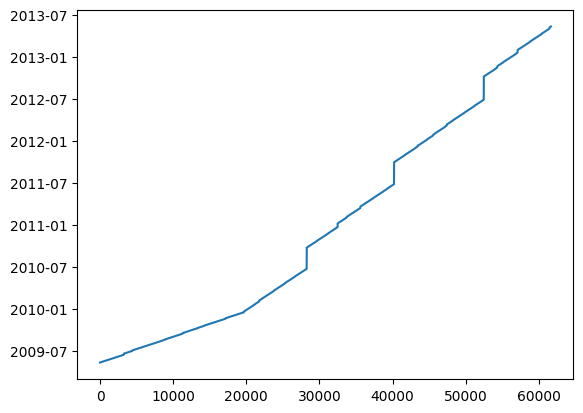

/tmp/ipykernel_6546/1493961019.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_nan = int(np.isnan(serie_f).sum())


                            time      flux  flux_err       date
0     2009-05-13 00:18:21.582315  1.525402  4.794427 2009-05-13
1     2009-05-13 00:47:47.106740  1.982319  4.798513 2009-05-13
2     2009-05-13 01:17:12.622516  1.313369  4.799855 2009-05-13
3     2009-05-13 01:46:38.129631  1.003761  4.796021 2009-05-13
4     2009-05-13 02:16:03.645386  1.306982  4.800775 2009-05-13
...                          ...       ...       ...        ...
64787 2013-05-11 10:05:15.439852 -1.706340  4.668090 2013-05-11
64788 2013-05-11 10:34:40.971676 -1.621687  4.666646 2013-05-11
64789 2013-05-11 11:04:06.494859 -1.685859  4.666482 2013-05-11
64790 2013-05-11 11:33:32.009397 -2.743378  4.656966 2013-05-11
64791 2013-05-11 12:02:57.541216 -2.398255  4.665851 2013-05-11

[64792 rows x 4 columns]


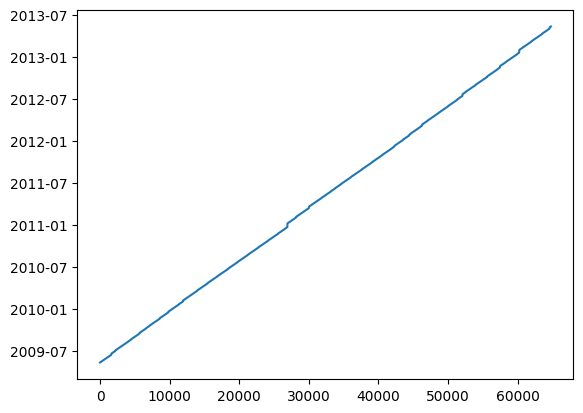

/tmp/ipykernel_6546/1493961019.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_nan = int(np.isnan(serie_f).sum())


                            time      flux  flux_err       date
0     2009-05-02 00:55:46.154565  0.372459  8.265691 2009-05-02
1     2009-05-02 01:25:11.692238 -0.331903  8.272369 2009-05-02
2     2009-05-02 01:54:37.221265 -0.007153  8.300896 2009-05-02
3     2009-05-02 02:24:02.767578  0.190490  8.287967 2009-05-02
4     2009-05-02 02:53:28.305255 -0.032380  8.270213 2009-05-02
...                          ...       ...       ...        ...
65258 2013-05-11 10:03:51.627170  0.340184  7.981848 2013-05-11
65259 2013-05-11 10:33:17.169559  0.351418  7.970239 2013-05-11
65260 2013-05-11 11:02:42.703315  0.227987  7.977660 2013-05-11
65261 2013-05-11 11:32:08.228438  0.308757  7.883888 2013-05-11
65262 2013-05-11 12:01:33.770850  0.446277  7.949580 2013-05-11

[65263 rows x 4 columns]


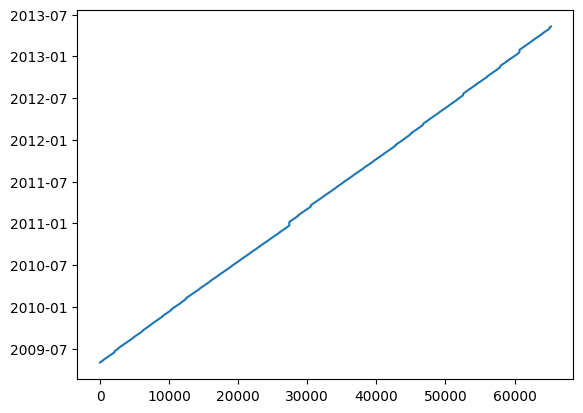

/tmp/ipykernel_6546/1493961019.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_nan = int(np.isnan(serie_f).sum())


                            time      flux  flux_err       date
0     2009-06-20 06:21:55.329895  0.071464  4.124198 2009-06-20
1     2009-06-20 06:51:20.856816 -0.548501  4.124689 2009-06-20
2     2009-06-20 07:20:46.366436  0.011347  4.125030 2009-06-20
3     2009-06-20 07:50:11.893315  0.141178  4.126250 2009-06-20
4     2009-06-20 08:19:37.402915  0.796199  4.126558 2009-06-20
...                          ...       ...       ...        ...
63165 2013-05-11 10:03:53.002183 -0.539282  3.763569 2013-05-11
63166 2013-05-11 10:33:18.545515  0.110227  3.758513 2013-05-11
63167 2013-05-11 11:02:44.080212  0.123335  3.765185 2013-05-11
63168 2013-05-11 11:32:09.606278 -0.837266  3.720991 2013-05-11
63169 2013-05-11 12:01:35.149632  0.035823  3.746708 2013-05-11

[63170 rows x 4 columns]


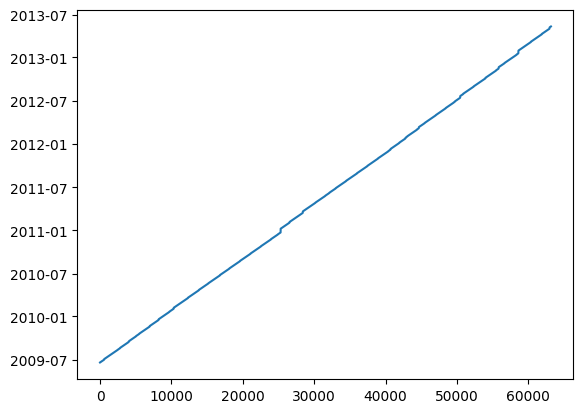

/tmp/ipykernel_6546/1493961019.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_nan = int(np.isnan(serie_f).sum())


                            time      flux  flux_err       date
0     2009-05-13 00:17:16.235586  1.200498  5.092520 2009-05-13
1     2009-05-13 00:46:41.760957  0.966729  5.089757 2009-05-13
2     2009-05-13 01:16:07.277688  1.906402  5.092396 2009-05-13
3     2009-05-13 01:45:32.785769  1.918808  5.090125 2009-05-13
4     2009-05-13 02:14:58.302490  2.313632  5.092269 2009-05-13
...                          ...       ...       ...        ...
64790 2013-05-11 10:04:14.817938  1.241211  5.091842 2013-05-11
64791 2013-05-11 10:33:40.340972  2.038105  5.091974 2013-05-11
64792 2013-05-11 11:03:05.855372  0.413497  5.091241 2013-05-11
64793 2013-05-11 11:32:31.361137  2.196212  5.089365 2013-05-11
64794 2013-05-11 12:01:56.884187  1.629016  5.085465 2013-05-11

[64795 rows x 4 columns]


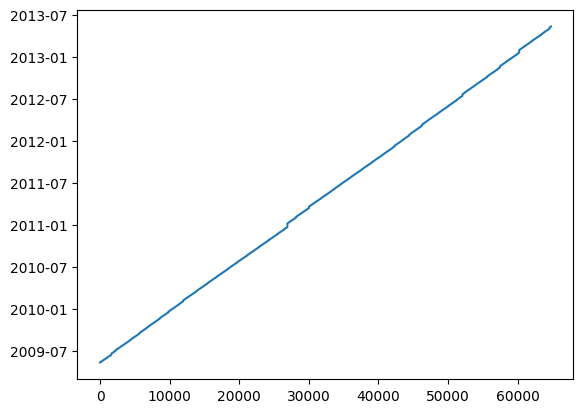

/tmp/ipykernel_6546/1493961019.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_nan = int(np.isnan(serie_f).sum())


KeyboardInterrupt: 

In [68]:
##############Prueba una curva de Luz##################
#lista de curvas que ya se arreglaron 
curvas_ready = os.listdir(url_lc_final)
curvas_ready_int = []
for file in curvas_ready:
    if file =='.ipynb_checkpoints':
        continue
    else:
        file = int(file[3:-4])
        curvas_ready_int.append(file)

# variable para porcentaje
total_curves = len(df_summary_final['ID'])
counter = 0
# for para procesar cada curva
for star in df_summary_final['ID'] :
    counter += 1
    if counter%20 == 0:
        print(counter/total_curves*100,5, "%")
        
    if star in curvas_ready_int :
        continue
    else:
        serie_p = pd.read_csv(url_lcc+"LC_"+str(star)+".csv")
        serie_p["time"] = pd.to_datetime(serie_p['time'])
        Serie_full = SerieFull(serie_p)
        k = InfoCurve(serie_p)[1]
        Serie_full = InterKNN(k,Serie_full)
        Serie_full = SinTrend(Serie_full).iloc[1:,]
        #end_time = time.time()
        Serie_full = Serie_full.drop(['time', 'flux_diff'], axis=1)
        Serie_full.to_csv(url_lc_final+"LC_"+str(star)+".csv", index=True)

In [ ]:
end_time-start_time